<h1 align="center">MSIN0114: Business Analytics Consulting Project</h1>
<h2 align="center">EDA and pre-processing for binary classification</h2>

# Table of Contents

* [Part 3](#part3): Pre-processing
    * [3.1](#3_1): Missing values
    * [3.2](#3_2): Conversion
    * [3.3](#3_3): Scaling
    * [3.4](#3_4): Feature engineering
    * [3.5](#3_5): Encoding
<br />
<br />
* [Part 4](#part4): Exploratory data analysis
<br />
<br />
* [Part 5](#part5): Feature engineering (cont.)

## Notebook Setup

In [1]:
# Essentials
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import sqlite3
import pyodbc
import numpy as np
import copy

# Image creation and display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

# Other
from statsmodels.stats.outliers_influence import variance_inflation_factor 
import itertools as it
import io
import os
os.sys.path
import sys
import glob
import concurrent.futures
from __future__ import print_function
import binascii
import struct
from PIL import Image
import scipy
import scipy.misc
import scipy.cluster
import datetime, time
import functools, operator
from datetime import datetime
from numpy.random import seed
from numpy.random import randn
from numpy import percentile

In [6]:
df = pd.read_csv('../csv-files/project_lvl.csv')

## Part 3: <a class="anchor" id="part3"></a> Pre-processing

### 3.1 <a class="anchor" id="3_1"></a> Missing values

In [81]:
print('Minimum values each column should have is set to be at least half of the dataset, i.e. '+ str(round(0.80 * len(df.columns)))+' rows.')

Minimum values each column should have is set to be at least half of the dataset, i.e. 22 rows.


In [82]:
# URL: https://datascience.stackexchange.com/questions/12645/how-to-count-the-number-of-missing-values-in-each-row-in-pandas-dataframe
df['non_missing_count'] = df.apply(lambda x: x.count(), axis=1)
df1 = df[(df['non_missing_count']) >= 22]

Use deepcopy function provided in the default package 'copy'. Making a deep copy breaks the reference to the original df. Hence, no more errors.

In [83]:
# URL: https://stackoverflow.com/questions/29888341/a-value-is-trying-to-be-set-on-a-copy-of-a-slice-from-a-dataframe-warning-even-a#:~:text=The%20common%20reason%20for%20the%20warning%20message%20%22A,slice%20dfA%20and%20both%20are%20linked%20to%20dfB.
df = copy.deepcopy(df1)

# See the number of columns having null values in the new dataset with dropped rows
cols = df.columns[df.isnull().any()].to_list()

for c in cols:
    print(c, df[c].isnull().sum())

Country 115
Director_ID 1
Director_Team 1
Director_Is_Recent 1
Director_Empl_Months 1
Perc_of_Subcontractors 154
Is_Front_Loaded 145
Delivered_on_Time 84
Avg_Rec 169
Avg_Profit 169


First, let's deal with small amount of nulls.

In [84]:
# Replacing null values with the most frequent strings and booleans - look up how to distribute them randomly, instead of most popular!
df['Country'].fillna(df['Country'].value_counts().idxmax(), inplace = True)
df['Director_ID'].fillna(df['Director_ID'].value_counts().idxmax(), inplace = True)
df['Director_Team'].fillna(df['Director_Team'].value_counts().idxmax(), inplace = True)
df['Director_Is_Recent'].fillna(df['Director_Is_Recent'].value_counts().idxmax(), inplace = True)
df['Manager_Is_Recent'].fillna(df['Manager_Is_Recent'].value_counts().idxmax(), inplace = True)
df['Director_Empl_Months'].fillna(df['Director_Empl_Months'].value_counts().idxmax(), inplace = True)
df['Is_Front_Loaded'].fillna(df['Is_Front_Loaded'].value_counts().idxmax(), inplace = True)
df['Delivered_on_Time'].fillna(df['Delivered_on_Time'].value_counts().idxmax(), inplace = True)

Whether to perform imputatipon of missed values with median or mean, always depends on data and task.If there is a dataset that have great outliers, or the distribution oof values does not follow the normal distribution, medians are preferred.

In [85]:
# Using median to impute the missing float values

missing_weeks = ['Project_Duration_Weeks']
for s in missing_weeks:
    df.loc[df.loc[:,s].isnull(),s]=int(df.loc[:,s].median())

missing_subcontractors = ['Perc_of_Subcontractors']
for s in missing_subcontractors:
    df.loc[df.loc[:,s].isnull(),s]=int(df.loc[:,s].median())

missing_rec = ['Avg_Rec']
for r in missing_rec:
    df.loc[df.loc[:,r].isnull(),r]=df.loc[:,r].median()
    
missing_profit = ['Avg_Profit']
for p in missing_profit:
    df.loc[df.loc[:,p].isnull(),p]=int(df.loc[:,p].median())

In [86]:
# Verify the changes
df.isnull().sum()

Project_ID                       0
Country                          0
Office                           0
Sector                           0
Project_Size_Sort_Order          0
Project_Duration_Weeks           0
Total_Num_Stages                 0
Is_Multi_Discipline_Project      0
Is_First_Client_Project          0
Default_Rate_Group               0
Perc_of_Stages_with_Fixed_Fee    0
Manager_ID                       0
Manager_Team                     0
Manager_Is_Recent                0
Manager_Empl_Months              0
Director_ID                      0
Director_Team                    0
Director_Is_Recent               0
Director_Empl_Months             0
Perc_of_Subcontractors           0
Is_Front_Loaded                  0
Delivered_on_Time                0
Suffered_Data_Loss               0
Total_Data_Issues                0
Avg_Rec                          0
Avg_Profit                       0
Project_Start_Date               0
Project_End_Date                 0
non_missing_count   

In [87]:
df.drop(columns = ['non_missing_count', 'Project_ID'], inplace = True)

### 3.2 <a class="anchor" id="3_2"></a> Conversion

In [88]:
# Convert the object column to boolean or integer where appropriate
df['Manager_Is_Recent'] = df['Manager_Is_Recent'].astype(int)
df['Director_ID'] = df['Director_ID'].astype('int64') # more specific, to be equal to Manager ID
df['Is_Front_Loaded'] = df['Is_Front_Loaded'].astype(int)
df['Suffered_Data_Loss'] = df['Is_Front_Loaded'].astype(int)
df['Total_Data_Issues'] = df['Total_Data_Issues'].astype(int)
df['Total_Num_Stages'] = df['Total_Num_Stages'].astype(int)

In [89]:
df['Director_Empl_Years'] = round(df['Director_Empl_Months']/12).astype(int)
df['Manager_Empl_Years'] = round(df['Manager_Empl_Months']/12).astype(int)
df.drop(columns = ['Director_Empl_Months', 'Manager_Empl_Months'], inplace=True)

### 3.3 <a class="anchor" id="3_3"></a> Scaling

<AxesSubplot:title={'center':'Relationship between profit and recoverability'}, xlabel='Avg_Rec', ylabel='Avg_Profit'>

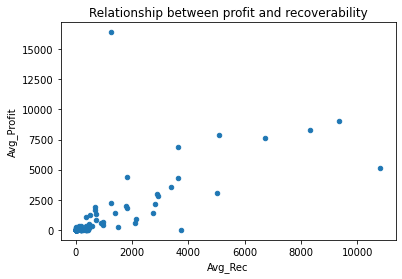

In [90]:
# No scaling
df.plot.scatter(x ='Avg_Rec', y ='Avg_Profit', title = 'Relationship between profit and recoverability')

<AxesSubplot:title={'center':'Relationship between profit and recoverability'}, xlabel='Avg_Rec', ylabel='Avg_Profit'>

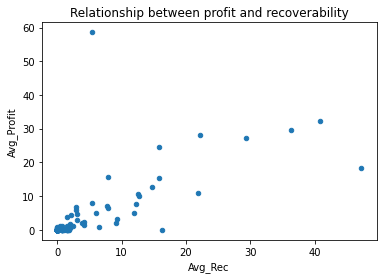

In [91]:
# Standardisation
df_std = df.copy()
df_std[['Avg_Rec', 'Avg_Profit']] = StandardScaler().fit_transform(df_std[['Avg_Rec', 'Avg_Profit']])
df_std.plot.scatter(x ='Avg_Rec', y ='Avg_Profit', title = 'Relationship between profit and recoverability')

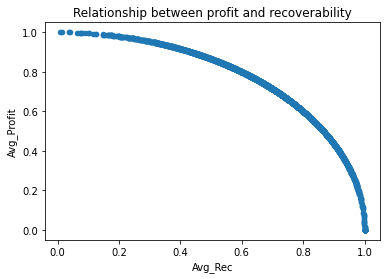

In [92]:
# Normalization
df_norm = df.copy()
df_norm[['Avg_Rec', 'Avg_Profit']] = preprocessing.normalize(df_norm[['Avg_Rec', 'Avg_Profit']])
df_norm.plot.scatter(x ='Avg_Rec', y ='Avg_Profit', title = 'Relationship between profit and recoverability')
plt.savefig('figures/eda/Relationship between profit and recoverability.png')
df = df_norm

### 3.4 <a class="anchor" id="3_4"></a> Feature engineering

#### 3.4.1 <a class="anchor" id="3_4_1"></a> Recoverability

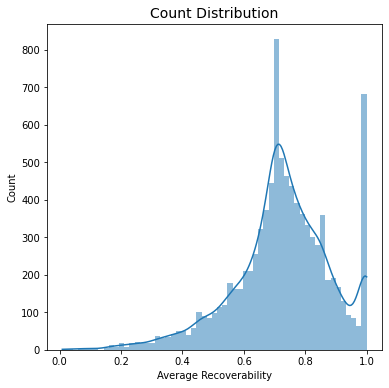

In [93]:
# Distribution of count of all points, with outliers
plt.figure(figsize=(6,6))
sns.histplot(df['Avg_Rec'], kde=True, linewidth=0)
plt.xlabel('Average Recoverability')
plt.title('Count Distribution', size=14)
plt.savefig('figures/eda/Recoverability count distribution.png')
plt.show()

<AxesSubplot:>

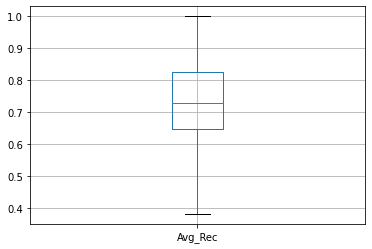

In [94]:
df.boxplot('Avg_Rec', showfliers=False) # boxplot without outliers, the green line corresponds to the median

Interpretation: https://www.mathbootcamps.com/how-to-read-a-boxplot/

<AxesSubplot:>

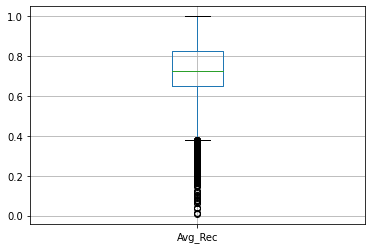

In [95]:
df.boxplot('Avg_Rec')

In [96]:
df['Avg_Rec'].quantile([0.25, 0.75], interpolation='nearest')

0.25    0.648717
0.75    0.827048
Name: Avg_Rec, dtype: float64

In [97]:
# Calculate the minimum and maximum bounds aside outliers
q1 = 0.648717
q3 = 0.827048
minimum = q1 - 1.5*(q3-q1)
maximum = q3 + 1.5*(q3-q1)

print('Minimum is ', str(minimum), '\nMaximum is ', str(maximum), '\nMedium is ', str(df['Avg_Rec'].median()))

Minimum is  0.38122049999999996 
Maximum is  1.0945445 
Medium is  0.7273888509014301


Now we can create 3 recoverability classes based on the median recoverability as our threshold.

In [98]:
rec_class = {}
for rec in df['Avg_Rec']:
  if rec < 0.648717:
    rec_class[rec] = 0  # nearly unrecoverable projects are below Q1
  elif rec > 0.7273888509014301:
    rec_class[rec] = 2 # very recoverable projects are above median
  else:
    rec_class[rec] = 1 # average recoverable projects are all the rest (between median and Q1)

In [99]:
rec_class_df = pd.DataFrame([{'Avg_Rec': rec, 'Rec_Class': rec_class} for (rec, rec_class) in rec_class.items()])
df = pd.merge(df, rec_class_df,  how='left', on='Avg_Rec')
df['Rec_Class'].replace([1], [0],inplace=True)
df['Rec_Class'].replace([2], [1],inplace=True)
df['Rec_Class'].value_counts()

0    4649
1    4648
Name: Rec_Class, dtype: int64

In [100]:
rec_class_df['Rec_Class'].value_counts()

2    3769
0    2228
1    1921
Name: Rec_Class, dtype: int64

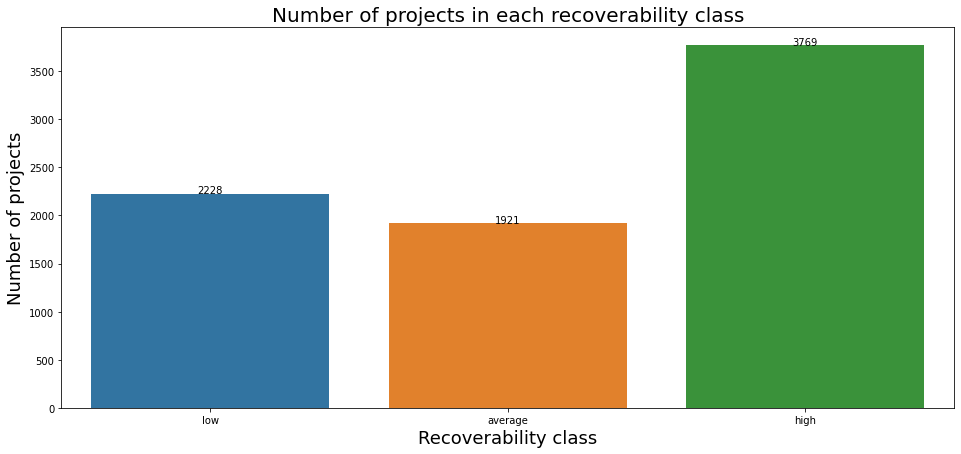

In [101]:
#URL: https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/#:~:text=Now%20use%20plt.text%20%28%29%20function%20to%20add%20value,the%20given%20co-ordinates%20i.e%2C%20i%20and%20y%20%5Bi%5D.

# Creating data on which bar chart will be plot
x = ['low', 'average', 'high']      
y = [2228, 1921, 3769]

plt.figure(figsize=(16,7))
ax = sns.barplot(x = x, y = y)

# Function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

# Calling the function to add value labels
addlabels(x, y)

plt.title('Number of projects in each recoverability class', fontsize=20)
plt.ylabel('Number of projects', fontsize=18)
plt.xlabel('Recoverability class', fontsize=18)
plt.savefig('figures/eda/Recoverability classes in multiclassification.png')

In [102]:
df['Rec_Class'].value_counts()

0    4649
1    4648
Name: Rec_Class, dtype: int64

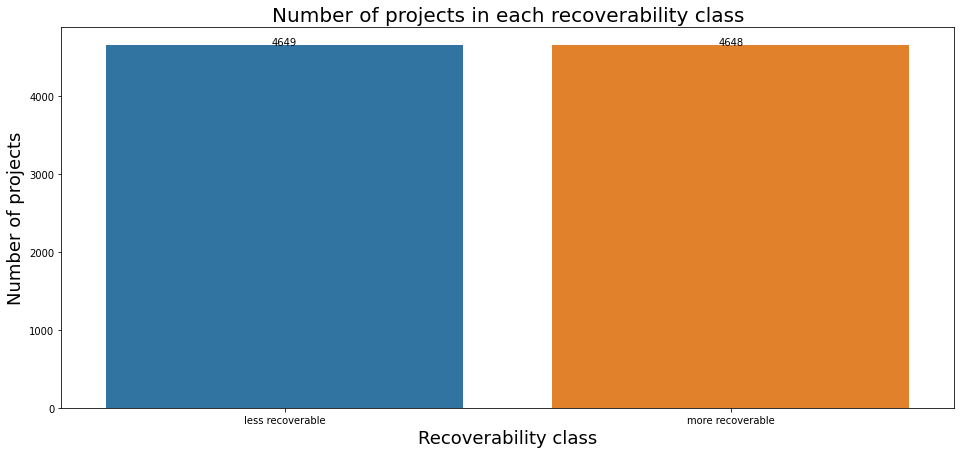

In [103]:
x = ['less recoverable', 'more recoverable']      
y = [4649, 4648]

plt.figure(figsize=(16,7))
ax = sns.barplot(x = x, y = y)
addlabels(x, y)

plt.title('Number of projects in each recoverability class', fontsize=20)
plt.ylabel('Number of projects', fontsize=18)
plt.xlabel('Recoverability class', fontsize=18)
plt.savefig('figures/eda/Recoverability classes in binary classification.png')

#### 3.4.2 <a class="anchor" id="3_4_2"></a> Profit

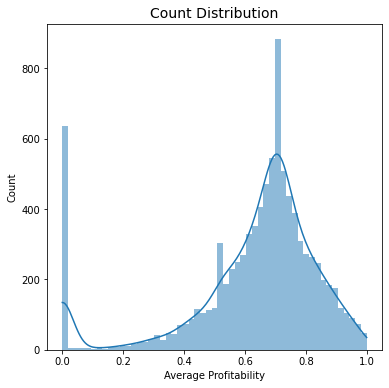

In [104]:
# Distribution of count of all points, with outliers
plt.figure(figsize=(6,6))
sns.histplot(df['Avg_Profit'], kde=True, linewidth=0)
plt.xlabel('Average Profitability')
plt.title('Count Distribution', size=14)
plt.savefig('figures/eda/Profitability count distribution.png')
plt.show()

<AxesSubplot:>

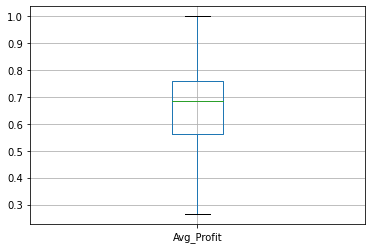

In [105]:
df.boxplot('Avg_Profit', showfliers=False) # boxplot without outliers, the green line corresponds to the median

<AxesSubplot:>

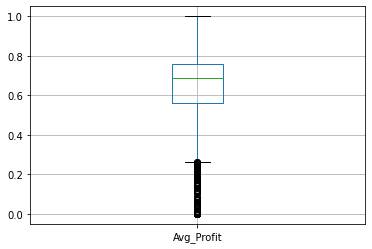

In [106]:
df.boxplot('Avg_Profit')

In [107]:
df['Avg_Profit'].quantile([0.25, 0.75], interpolation='nearest')

0.25    0.562131
0.75    0.761030
Name: Avg_Profit, dtype: float64

In [108]:
# Calculate the minimum and maximum bounds aside outliers
q1 = 0.562131
q3 = 0.761030
minimum = q1 - 1.5*(q3-q1)
maximum = q3 + 1.5*(q3-q1)

print('Minimum is ', str(minimum), '\nMaximum is ', str(maximum), '\nMedium is ', str(df['Avg_Profit'].median()))

Minimum is  0.26378250000000014 
Maximum is  1.0593784999999998 
Medium is  0.6862255165645598


Now we can create 3 profit measure classes based on the median profit measurement as our threshold.

In [109]:
profit_class = {}
for profit in df['Avg_Profit']:
  if profit < 0.562131:
    profit_class[profit] = 0  # nearly unprofitable projects are below Q1
  elif profit > 0.6862255165645598:
    profit_class[profit] = 2 # very profitable projects are above mean
  else:
    profit_class[profit] = 1 # average profitable projects are in the interquartile range

In [110]:
pr_class_df = pd.DataFrame([{'Avg_Profit': pr, 'Profit_Class': profit_class} for (pr, profit_class) in profit_class.items()])
df = pd.merge(df, pr_class_df,  how='left', on='Avg_Profit')
df['Profit_Class'].replace([1], [0],inplace=True)
df['Profit_Class'].replace([2], [1],inplace=True)
df['Profit_Class'].value_counts()

0    4649
1    4648
Name: Profit_Class, dtype: int64

In [111]:
pr_class_df['Profit_Class'].value_counts()

2    4141
1    2274
0    1501
Name: Profit_Class, dtype: int64

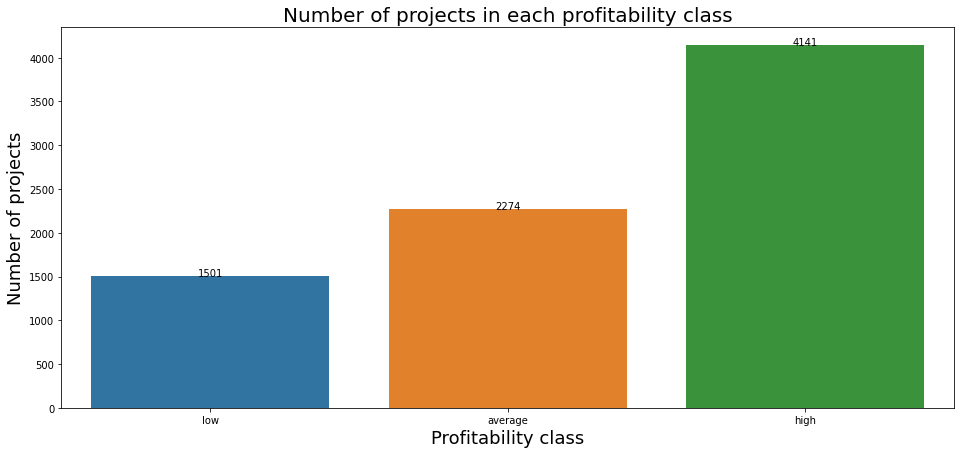

In [112]:
x = ['low', 'average', 'high']      
y = [1501, 2274, 4141]

plt.figure(figsize=(16,7))
ax = sns.barplot(x = x, y = y)
addlabels(x, y)

plt.title('Number of projects in each profitability class', fontsize=20)
plt.ylabel('Number of projects', fontsize=18)
plt.xlabel('Profitability class', fontsize=18)
plt.savefig('figures/eda/Profitability classes in multiclassification.png')

In [113]:
df['Profit_Class'].value_counts()

0    4649
1    4648
Name: Profit_Class, dtype: int64

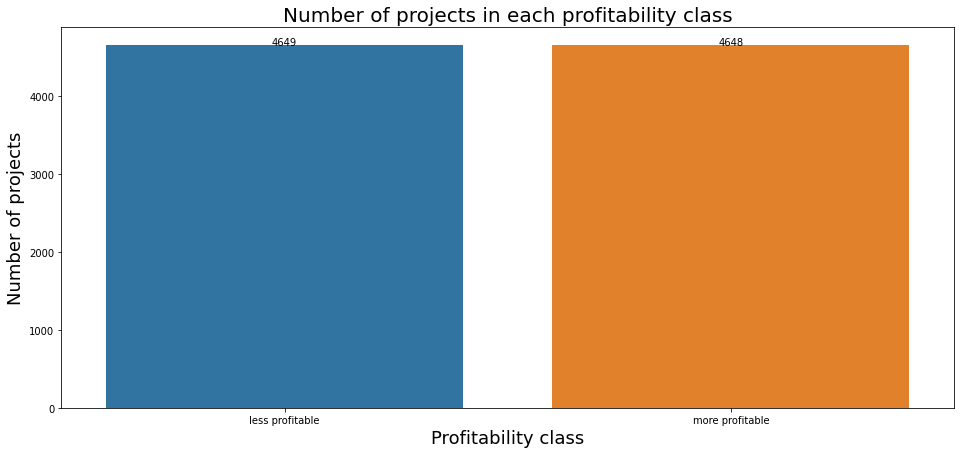

In [114]:
x = ['less profitable', 'more profitable']      
y = [4649, 4648]

plt.figure(figsize=(16,7))
ax = sns.barplot(x = x, y = y)
addlabels(x, y)

plt.title('Number of projects in each profitability class', fontsize=20)
plt.ylabel('Number of projects', fontsize=18)
plt.xlabel('Profitability class', fontsize=18)
plt.savefig('figures/eda/Profitability classes in binary classification.png')

In [115]:
df.drop(columns = ['Avg_Rec', 'Avg_Profit'], inplace = True)

#### 3.4.3 <a class="anchor" id="3_4_3"></a> Project time quaters

In [116]:
df['Project_Start_Date'] = pd.to_datetime(df['Project_Start_Date'])
df['Project_End_Date'] = pd.to_datetime(df['Project_End_Date'])
df['Project_Start_Date'] = df['Project_Start_Date'].dt.quarter
df['Project_End_Date'] = df['Project_End_Date'].dt.quarter
df.rename(columns = {'Project_Start_Date':'Start_Quarter', 'Project_End_Date':'End_Quarter'}, inplace=True)

### 3.5 <a class="anchor" id="3_3"></a> Encoding

#### 3.5.1 <a class="anchor" id="3_5_1"></a> One hot encoding

In [117]:
cat_vars = (df.select_dtypes(include=object))
cat_vars.columns

Index(['Country', 'Office', 'Sector', 'Default_Rate_Group', 'Manager_Team',
       'Director_Team'],
      dtype='object')

In [118]:
df['Country'].nunique()

11

In [119]:
df['Office'].nunique()

8

In [120]:
df['Sector'].nunique()

12

In [121]:
df['Default_Rate_Group'].nunique()

2

In [122]:
df['Manager_Team'].nunique()

22

In [123]:
df['Manager_Team'].value_counts()

SA - Civil                         2149
SA - Industrial                    1747
SA - Buildings                     1720
VIC - Buildings                    1046
All Staff                           413
VIC - Support Services              333
Group - Support Services            299
WA - Structural                     240
WA - Industrial                     200
WA - Maritime                       188
NZ - Water                          138
QLD - QLD                           125
WA - Civil                          124
VIC - Traffic                       122
WA - Project Delivery Services      108
SA - Project Delivery Services       87
VIC - Infrastructure                 83
VIC - Industrial                     81
VIC - Project Delivery Services      52
WA - Support Services                21
VIC - Geotechnical                   20
SA - Finance                          1
Name: Manager_Team, dtype: int64

In [124]:
for x in df['Manager_Team']:
    if x.startswith('SA') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'SA', inplace=True)
    elif x.startswith('VIC') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'VIC', inplace=True)
    elif x.startswith('WA') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'WA', inplace=True)
    elif x.startswith('NZ') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'NZ', inplace=True)
    elif x.startswith('QLD') == True:
        df['Manager_Team'].mask(df['Manager_Team'] == x, 'QLD', inplace=True)

In [125]:
df['Manager_Team'].value_counts()

SA                          5704
VIC                         1737
WA                           881
All Staff                    413
Group - Support Services     299
NZ                           138
QLD                          125
Name: Manager_Team, dtype: int64

In [126]:
df['Manager_Team'].nunique()

7

In [127]:
df['Director_Team'].nunique()

16

In [128]:
df['Director_Team'].value_counts()

SA - Buildings                    2381
SA - Industrial                   1918
SA - Civil                        1667
VIC - Support Services            1448
WA - Maritime                      666
Group - Support Services           601
VIC - Buildings                    184
WA - Structural                    136
SA - Project Delivery Services      86
WA - Civil                          73
VIC - Traffic                       61
VIC - Infrastructure                47
VIC - Geotechnical                  10
All Staff                            8
QLD - QLD                            6
NZ - Water                           5
Name: Director_Team, dtype: int64

In [129]:
for x in df['Director_Team']:
    if x.startswith('SA') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'SA', inplace=True)
    elif x.startswith('VIC') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'VIC', inplace=True)
    elif x.startswith('WA') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'WA', inplace=True)
    elif x.startswith('NZ') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'NZ', inplace=True)
    elif x.startswith('QLD') == True:
        df['Director_Team'].mask(df['Director_Team'] == x, 'QLD', inplace=True)

In [130]:
df['Director_Team'].value_counts()

SA                          6052
VIC                         1750
WA                           875
Group - Support Services     601
All Staff                      8
QLD                            6
NZ                             5
Name: Director_Team, dtype: int64

In [131]:
df['Director_Team'].nunique()

7

In [132]:
df_extended = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=True, dtype=None)
df_extended

,Project_Size_Sort_Order,Project_Duration_Weeks,Total_Num_Stages,Is_Multi_Discipline_Project,Is_First_Client_Project,Perc_of_Stages_with_Fixed_Fee,Manager_ID,Manager_Is_Recent,Director_ID,Director_Is_Recent,Perc_of_Subcontractors,Is_Front_Loaded,Delivered_on_Time,Suffered_Data_Loss,Total_Data_Issues,Start_Quarter,End_Quarter,Director_Empl_Years,Manager_Empl_Years,Rec_Class,Profit_Class,Country_Botswana,Country_China,Country_New Zealand,Country_Papua New Guinea,Country_Peru,Country_Samoa,Country_Saudi Arabia,Country_Tonga,Country_United Arab Emirates,Country_Zambia,Office_Inception Consulting Engineers Pty Ltd,Office_WGANZ Pty Ltd,Office_WGAQLD Pty Ltd,Office_WGASA Pty Ltd,Office_WGAVIC Pty Ltd,Office_WGAWA Pty Ltd,Office_Whyalla,Sector_Commercial & Retail Buildings,Sector_Defence & Space,Sector_Energy,Sector_Health & Aged Care,"Sector_Justice, Corrections & Emergency Services",Sector_Ports & Marine,Sector_Resources,Sector_Sport & Recreation Facilities,Sector_Traffic Transport (Bridges),Sector_Urban development,Sector_Water/Waste,Default_Rate_Group_Standard,Manager_Team_Group - Support Services,Manager_Team_NZ,Manager_Team_QLD,Manager_Team_SA,Manager_Team_VIC,Manager_Team_WA,Director_Team_Group - Support Services,Director_Team_NZ,Director_Team_QLD,Director_Team_SA,Director_Team_VIC,Director_Team_WA
0,4.0,4.0,5,0.0,1.0,0.80,7612852,0,7612709,False,0.0,1,True,1,2,3,3,36,11,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
1,1.0,238.0,4,0.0,1.0,0.00,7612773,0,7612747,False,0.0,0,True,0,2,3,2,36,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
2,1.0,0.0,2,0.0,1.0,0.00,7612773,0,7612768,False,0.0,0,True,0,0,1,1,28,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
3,3.0,121.0,4,0.0,1.0,0.25,7612773,0,7612709,False,0.0,0,True,0,1,4,2,36,27,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
4,7.0,2.0,6,0.0,1.0,0.00,7612695,0,7612695,False,0.0,0,True,0,3,3,3,35,35,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9292,3.0,18.0,2,0.0,0.0,1.00,7612752,0,7612691,False,0.0,0,True,0,1,2,3,15,15,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
9293,1.0,1.0,3,0.0,0.0,0.67,9501752,0,7859152,False,0.0,0,True,0,1,2,2,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
9294,1.0,1.0,2,0.0,0.0,0.50,7809410,0,10018105,True,0.0,0,True,0,1,2,2,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
9295,1.0,3.0,1,0.0,0.0,1.00,7612860,0,7612841,False,0.0,0,True,0,0,2,2,24,14,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


#### 3.5.2 <a class="anchor" id="3_5_2"></a> Label encoding

In [133]:
le = LabelEncoder()
df['Country'] = le.fit_transform(df['Country'])
df['Office'] = le.fit_transform(df['Office'])
df['Sector'] = le.fit_transform(df['Sector'])
df['Default_Rate_Group'] = le.fit_transform(df['Default_Rate_Group'])
df['Manager_Team'] = le.fit_transform(df['Manager_Team'])
df['Director_Team'] = le.fit_transform(df['Director_Team'])
df['Director_Is_Recent'] = df['Director_Is_Recent']*1
df['Delivered_on_Time'] = df['Delivered_on_Time']*1

## Part 4: <a class="anchor" id="part4"></a> Exploratory data analysis

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_7140\1446604740.py:9: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(visible=False, color='#f68c1f', alpha=0.1)


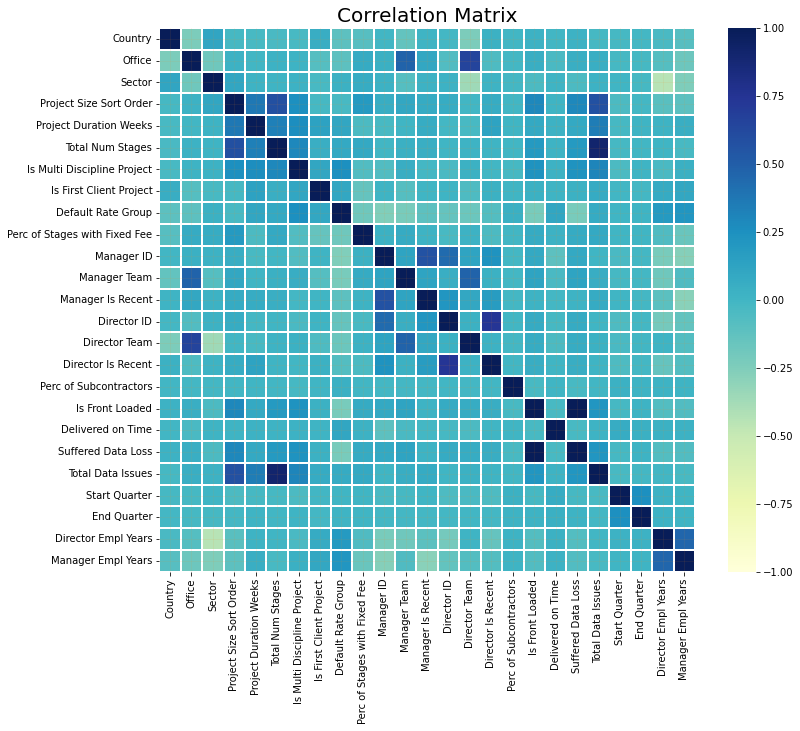

In [135]:
X = df.drop(['Rec_Class', 'Profit_Class'], axis = 1).copy()
X.columns = X.columns.str.replace('_', ' ')

corr = X.corr()
colors = sns.diverging_palette(37, 12.5, as_cmap = True)
plt.labels = []
plt.figure(figsize = (12,10))
sns.heatmap(round(corr, 3), vmin=-1, vmax=1, cmap='YlGnBu', linewidths=.2)
plt.grid(visible=False, color='#f68c1f', alpha=0.1)
plt.title('Correlation Matrix', size = 20)
plt.savefig('figures/eda/Correlation matrix.png')
plt.show()

In [136]:
vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

c:\Users\MarfaPopova\S2R Analytics\Development & Support Team - Power BI for Synergy - Advanced Analytics\DataFlowExtract\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,Column
17,inf,Is Front Loaded
19,inf,Suffered Data Loss
13,1998.746462,Director ID
10,1553.999766,Manager ID
18,249.631452,Delivered on Time
1,55.573877,Office
14,35.464685,Director Team
11,16.805281,Manager Team
23,10.971967,Director Empl Years
5,8.676885,Total Num Stages


In [137]:
df['Suffered_Data_Loss'].value_counts()

0    6927
1    2370
Name: Suffered_Data_Loss, dtype: int64

In [138]:
df['Is_Front_Loaded'].value_counts()

0    6927
1    2370
Name: Is_Front_Loaded, dtype: int64

In [139]:
df.drop(columns = ['Suffered_Data_Loss'], inplace = True)

X = df.drop(['Rec_Class', 'Profit_Class'], axis = 1).copy()

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
13,1998.746462,Director_ID
10,1553.999766,Manager_ID
18,249.631452,Delivered_on_Time
1,55.573877,Office
14,35.464685,Director_Team
11,16.805281,Manager_Team
22,10.971967,Director_Empl_Years
5,8.676885,Total_Num_Stages
19,8.132417,Total_Data_Issues
21,6.896107,End_Quarter


In [140]:
# URL: https://stats.stackexchange.com/questions/155028/how-to-systematically-remove-collinear-variables-pandas-columns-in-python   

def calculate_vif_(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

calculate_vif_(df)

dropping 'Director_ID' at index: 13
dropping 'Manager_ID' at index: 10
dropping 'Delivered_on_Time' at index: 16
dropping 'Office' at index: 1
dropping 'Rec_Class' at index: 20
dropping 'Director_Team' at index: 11
dropping 'Total_Num_Stages' at index: 4
dropping 'Director_Empl_Years' at index: 16
dropping 'Manager_Team' at index: 8
dropping 'End_Quarter' at index: 14
dropping 'Project_Size_Sort_Order' at index: 2
Remaining variables:
Index(['Country', 'Sector', 'Project_Duration_Weeks',
       'Is_Multi_Discipline_Project', 'Is_First_Client_Project',
       'Default_Rate_Group', 'Perc_of_Stages_with_Fixed_Fee',
       'Manager_Is_Recent', 'Director_Is_Recent', 'Perc_of_Subcontractors',
       'Is_Front_Loaded', 'Total_Data_Issues', 'Start_Quarter',
       'Manager_Empl_Years', 'Profit_Class'],
      dtype='object')


,Country,Sector,Project_Duration_Weeks,Is_Multi_Discipline_Project,Is_First_Client_Project,Default_Rate_Group,Perc_of_Stages_with_Fixed_Fee,Manager_Is_Recent,Director_Is_Recent,Perc_of_Subcontractors,Is_Front_Loaded,Total_Data_Issues,Start_Quarter,Manager_Empl_Years,Profit_Class
0,0,6,4.0,0.0,1.0,1,0.80,0,0,0.0,1,2,3,11,0
1,0,0,238.0,0.0,1.0,1,0.00,0,0,0.0,0,2,3,27,0
2,0,0,0.0,0.0,1.0,1,0.00,0,0,0.0,0,0,1,27,0
3,0,1,121.0,0.0,1.0,1,0.25,0,0,0.0,0,1,4,27,0
4,0,0,2.0,0.0,1.0,1,0.00,0,0,0.0,0,3,3,35,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9292,0,9,18.0,0.0,0.0,0,1.00,0,0,0.0,0,1,2,15,0
9293,0,0,1.0,0.0,0.0,0,0.67,0,0,0.0,0,1,2,1,0
9294,0,0,1.0,0.0,0.0,0,0.50,0,1,0.0,0,1,2,2,0
9295,0,3,3.0,0.0,0.0,0,1.00,0,0,0.0,0,0,2,14,0


## Part 5: <a class="anchor" id="part5"></a> Feature engineering (cont.)

In [141]:
df['Manager_AND_Director'] = (df['Manager_ID'] == df['Director_ID'])*1
df['Manager_AND_Director'].value_counts()

0    7605
1    1692
Name: Manager_AND_Director, dtype: int64

In [142]:
df['Are_Same_Teams'] = (df['Manager_Team'] == df['Director_Team'])*1
df['Are_Same_Teams'].value_counts()

1    7837
0    1460
Name: Are_Same_Teams, dtype: int64

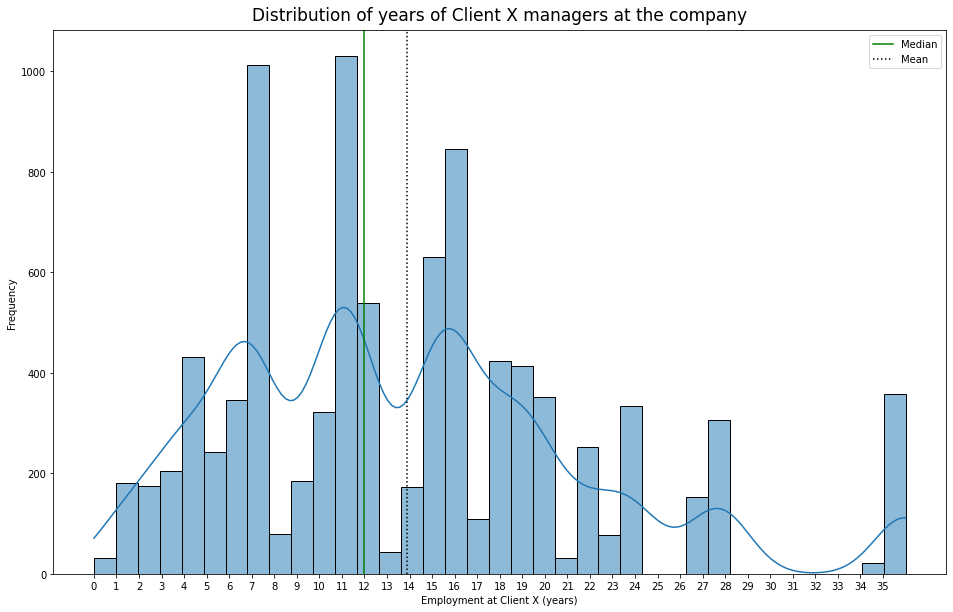

In [65]:
# URL: https://medium.com/p/5f093ad7b9d3
manager = df['Manager_Empl_Years']
fig, ax = plt.subplots(figsize = (16,10))
test = sns.histplot(manager, bins = 37, kde=True, linewidth=1)

plt.xlabel('Employment at Client X (years)')
ax.set_xticks(range(max(df['Manager_Empl_Years'])))
ax.set_xticklabels(range(max(df['Manager_Empl_Years'])))
plt.ylabel('Frequency')

median=manager.median()
plt.axvline(median, color='green', linestyle='-', label='Median')
mean=manager.mean()
ax.axvline(mean, color='black', linestyle=':', label='Mean')
ax.legend()
ax.grid(False)
ax.set_title('Distribution of years of Client X managers at the company', size = 17, pad = 10)
plt.savefig('figures/eda/Distribution of years of Client X managers at the company.png')

In [66]:
(df['Manager_Empl_Years'] > 12).sum()

4521

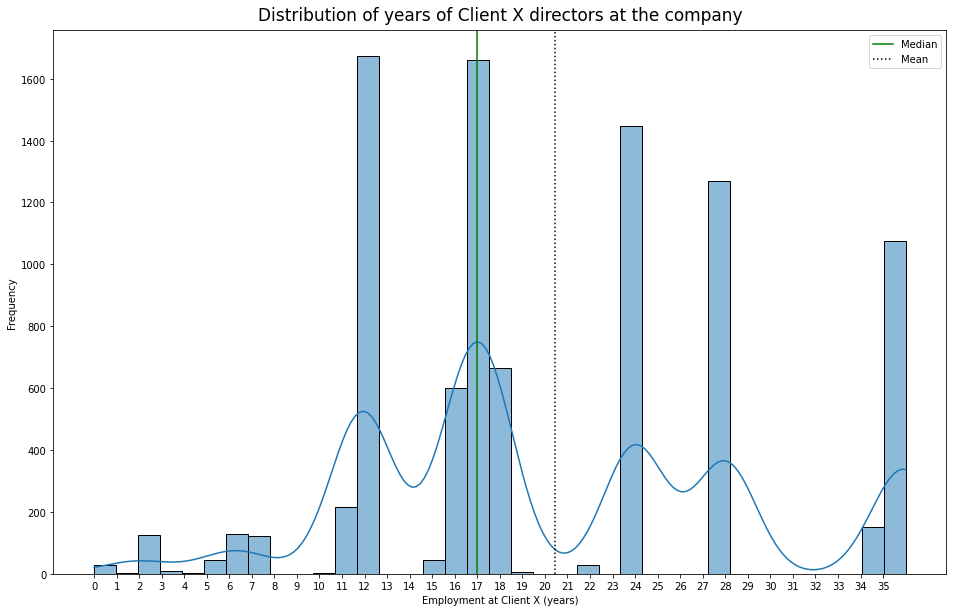

In [67]:
director = df['Director_Empl_Years']
fig, ax = plt.subplots(figsize = (16,10))
test = sns.histplot(director, bins = 37, kde=True, linewidth=1)

plt.xlabel('Employment at Client X (years)')
ax.set_xticks(range(max(df['Director_Empl_Years'])))
ax.set_xticklabels(range(max(df['Director_Empl_Years'])))
plt.ylabel('Frequency')

median=director.median()
plt.axvline(median, color='green', linestyle='-', label='Median')
mean=director.mean()
ax.axvline(mean, color='black', linestyle=':', label='Mean')
ax.legend()
ax.grid(False)
ax.set_title('Distribution of years of Client X directors at the company', size = 17, pad = 10)
plt.savefig('figures/eda/Distribution of years of Client X directors at the company.png')

In [143]:
(df['Director_Empl_Years'] > 17).sum()

4643

In [144]:
df['LT_Manager'] = (df['Manager_Empl_Years'] > 12)*1
df['LT_Director'] = (df['Director_Empl_Years'] > 17)*1
df['MG_DR_Skilled'] = (df['LT_Manager'] + df['LT_Director'])
df.drop(columns = ['LT_Manager', 'LT_Director'], inplace = True)

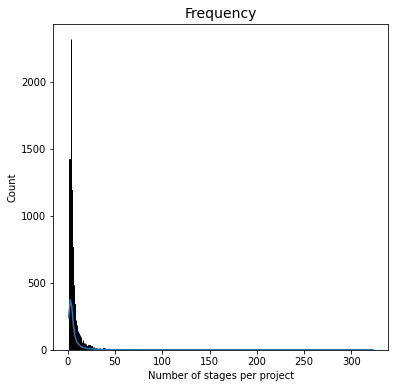

In [145]:
# Distribution of count of all points, with outliers
plt.figure(figsize=(6,6))
sns.histplot(df['Total_Num_Stages'], kde=True, linewidth=1)
plt.xlabel('Number of stages per project')
plt.title('Frequency', size=14)
plt.show()

<AxesSubplot:>

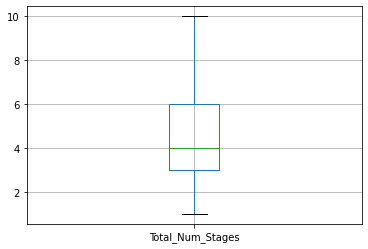

In [146]:
df.boxplot('Total_Num_Stages', showfliers=False) # boxplot without outliers, the green line corresponds to the median

In [147]:
df['Total_Num_Stages'].quantile([0.25, 0.75], interpolation='nearest')

0.25    3
0.75    6
Name: Total_Num_Stages, dtype: int32

In [148]:
complexity = {}
for stages in df['Total_Num_Stages']:
  if stages < 4:
    complexity[stages] = 0  # easy projects have less than average number of stages
  elif stages > 10:
    complexity[stages] = 2 # hard projects are above upper bound
  else:
    complexity[stages] = 1 # the rest of projects are of average complexity

complexity_df = pd.DataFrame([{'Total_Num_Stages': stages, 'Complexity_Level': complexity} for (stages, complexity) in complexity.items()])
df = pd.merge(df, complexity_df,  how='left', on='Total_Num_Stages')
df['Complexity_Level'].value_counts()

0    4635
1    3451
2    1211
Name: Complexity_Level, dtype: int64

In [149]:
df.drop(columns = ['Director_ID', 'Manager_ID', 'Director_Team', 'Manager_Team', 'Delivered_on_Time', 'Office', 'Director_Empl_Years', 'Manager_Empl_Years', 'Total_Num_Stages'], inplace = True)

X = df.drop(['Rec_Class', 'Profit_Class'], axis = 1).copy()

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_info['Column'] = X.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
2,6.849013,Project_Size_Sort_Order
14,6.200886,End_Quarter
16,5.825412,Are_Same_Teams
13,5.766345,Start_Quarter
6,4.328092,Default_Rate_Group
18,4.291627,Complexity_Level
7,4.181978,Perc_of_Stages_with_Fixed_Fee
17,3.263781,MG_DR_Skilled
1,3.063222,Sector
12,2.199590,Total_Data_Issues


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9297 entries, 0 to 9296
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        9297 non-null   int32  
 1   Sector                         9297 non-null   int32  
 2   Project_Size_Sort_Order        9297 non-null   float64
 3   Project_Duration_Weeks         9297 non-null   float64
 4   Is_Multi_Discipline_Project    9297 non-null   float64
 5   Is_First_Client_Project        9297 non-null   float64
 6   Default_Rate_Group             9297 non-null   int32  
 7   Perc_of_Stages_with_Fixed_Fee  9297 non-null   float64
 8   Manager_Is_Recent              9297 non-null   int32  
 9   Director_Is_Recent             9297 non-null   int32  
 10  Perc_of_Subcontractors         9297 non-null   float64
 11  Is_Front_Loaded                9297 non-null   int32  
 12  Total_Data_Issues              9297 non-null   i

C:\Users\MarfaPopova\AppData\Local\Temp\ipykernel_7140\2761898691.py:9: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(visible=False, color='#f68c1f', alpha=0.1)


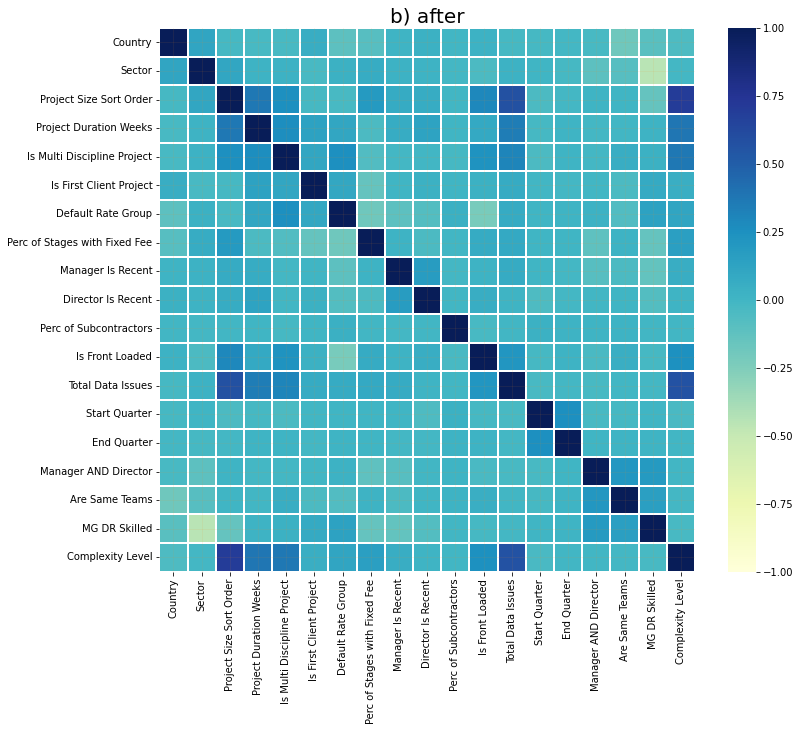

In [150]:
X = df.drop(['Rec_Class', 'Profit_Class'], axis = 1).copy()
X.columns = X.columns.str.replace('_', ' ')

corr = X.corr()
colors = sns.diverging_palette(37, 12.5, as_cmap = True)
plt.labels = []
plt.figure(figsize = (12,10))
sns.heatmap(round(corr, 3), vmin=-1, vmax=1, cmap='YlGnBu', linewidths=.2)
plt.grid(visible=False, color='#f68c1f', alpha=0.1)
plt.title('b) after', size = 20)
plt.show()

In [ ]:
df.to_csv('../csv-files/binary_data.csv', index=False)